In [2]:
from math import pi

import lenstronomy.Util.param_util as param_util
import torch
from astropy.cosmology import FlatLambdaCDM as FlatLambdaCDM_ap
from lenstronomy.LensModel.lens_model import LensModel

from caustic.cosmology import FlatLambdaCDM
from caustic.lenses import SIE, Multiplane
from typing import Any, Dict, List, Union

import numpy as np
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel

from caustic.lenses import ThinLens
from caustic.lenses.base import ThickLens
from caustic.utils import get_meshgrid

/home/charles/miniconda3/envs/caustic/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
from typing import Any, Dict, List, Union

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel

from caustic.lenses import ThinLens
from caustic.lenses.base import ThickLens
from caustic.utils import get_meshgrid


def setup_grids(res=0.05, n_pix=100):
    # Caustic setup
    thx, thy = get_meshgrid(res, n_pix, n_pix)

    # Lenstronomy setup
    fov = res * n_pix
    ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
    kwargs_pixel = {
        "nx": n_pix,
        "ny": n_pix,  # number of pixels per axis
        "ra_at_xy_0": ra_at_xy_0,
        "dec_at_xy_0": dec_at_xy_0,
        "transform_pix2angle": transform_pix2angle,
    }
    pixel_grid = PixelGrid(**kwargs_pixel)
    thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)
    return thx, thy, thx_ls, thy_ls


def alpha_test_helper(lens, lens_ls, z_s, x, kwargs_ls, atol, rtol):
    thx, thy, thx_ls, thy_ls = setup_grids()
    alpha_x, alpha_y = lens.reduced_deflection_angle(thx, thy, z_s, lens.pack(x))
    alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)
    # print(alpha_x.numpy()[:10,:10])
    # print(alpha_x_ls[:10,:10])

    display(alpha_x)
    display(alpha_x_ls)
    display(alpha_x - alpha_x_ls)
    display((alpha_x / alpha_x_ls).log())
    display((alpha_x / alpha_x_ls) - (alpha_x / alpha_x_ls).max())
    
    assert np.allclose(alpha_x.numpy(), alpha_x_ls, rtol, atol)
    assert np.allclose(alpha_y.numpy(), alpha_y_ls, rtol, atol)


def Psi_test_helper(lens, lens_ls, z_s, x, kwargs_ls, atol, rtol):
    thx, thy, thx_ls, thy_ls = setup_grids()
    Psi = lens.potential(thx, thy, z_s, lens.pack(x))
    Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)
    # Potential is only defined up to a constant
    Psi -= Psi.min()
    Psi_ls -= Psi_ls.min()

    display(Psi, cmap="hot", norm=None)
    display(Psi_ls, cmap="hot", norm=None)
    display(Psi - Psi_ls)
    
    assert np.allclose(Psi.numpy(), Psi_ls, rtol, atol)


def kappa_test_helper(lens, lens_ls, z_s, x, kwargs_ls, atol, rtol):
    thx, thy, thx_ls, thy_ls = setup_grids()
    kappa = lens.convergence(thx, thy, z_s, lens.pack(x))
    kappa_ls = lens_ls.kappa(thx_ls, thy_ls, kwargs_ls)

    display(kappa, cmap="twilight_r", norm=None)
    display(kappa_ls, cmap="twilight_r", norm=None)
    display(kappa - kappa_ls)
    
    assert np.allclose(kappa.numpy(), kappa_ls, rtol, atol)

def lens_test_helper(
    lens: Union[ThinLens, ThickLens],
    lens_ls: LensModel,
    z_s,
    x,
    kwargs_ls: List[Dict[str, Any]],
    rtol,
    atol,
    test_alpha=True,
    test_Psi=True,
    test_kappa=True,
):
    if test_alpha:
        alpha_test_helper(lens, lens_ls, z_s, lens.pack(x), kwargs_ls, atol, rtol)

    if test_Psi:
        Psi_test_helper(lens, lens_ls, z_s, lens.pack(x), kwargs_ls, atol, rtol)

    if test_kappa:
        kappa_test_helper(lens, lens_ls, z_s, lens.pack(x), kwargs_ls, atol, rtol)


In [4]:
import numpy as np
import os
from glob import glob
import pandas as pd
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid

def display(arr, ax=None, lim=1, mid=0, title=None, fs=12, norm="Centered", cmap="bwr", cbar=True, axis=False):
	show = False
	if ax is None:
		fig, ax = plt.subplots(figsize=(6,6))
		show = True

	norm_kw = {}
	if norm == "Centered":
		norm_kw.update({"norm": colors.CenteredNorm(vcenter=mid)})
	elif norm == "Log":
		norm_kw.update({"norm": colors.LogNorm()})

	
	im = ax.imshow(arr, origin='lower', extent=(-lim, lim, -lim, lim),
				   cmap=cmap, **norm_kw)

	if cbar:
		div = make_axes_locatable(ax)
		cax = div.append_axes("right", size="5%", pad=0.1)
		plt.colorbar(im, cax=cax)

	tx = None
	if title is not None:
		tx = ax.set_title(title, fontsize=fs)

	if not axis:
		ax.axis("off")
		
	if show:
		plt.show()
		plt.close()

	return im, tx

## Multiplane class

In [9]:
from operator import itemgetter
from typing import Any, Optional

import torch
from torch import Tensor

from caustic.cosmology import Cosmology
from caustic.lenses.base import ThickLens, ThinLens

__all__ = ("Multiplane",)

class Multiplane(ThickLens):
    """
    Class for handling gravitational lensing with multiple lens planes.

    Attributes:
        lenses (list[ThinLens]): List of thin lenses.

    Args:
        name (str): Name of the lens.
        cosmology (Cosmology): Cosmological parameters used for calculations.
        lenses (list[ThinLens]): List of thin lenses.
    """
    def __init__(self, name: str, cosmology: Cosmology, lenses: list[ThinLens]):
        super().__init__(name, cosmology)
        self.lenses = lenses
        for lens in lenses:
            self.add_parametrized(lens)

    def get_z_ls(self, params: Optional["Packed"]) -> list[Tensor]:
        """
        Get the redshifts of each lens in the multiplane.

        Args:
            params (Packed, optional): Dynamic parameter container.

        Returns:
            List[Tensor]: Redshifts of the lenses.
        """
        # Relies on z_l being the first element to be unpacked, which should always
        # be the case for a ThinLens
        return [lens.unpack(params)[0] for lens in self.lenses]

    def raytrace(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> tuple[Tensor, Tensor]:
        """Calculate the angular source positions corresponding to the
        observer positions x,y. See Margarita et al. 2013 for the
        formalism from the GLAMER -II code:
        https://ui.adsabs.harvard.edu/abs/2014MNRAS.445.1954P/abstract

        Args:
            x (Tensor): angular x-coordinates from the observer perspective.
            y (Tensor): angular y-coordinates from the observer perspective.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            tuple[Tensor, Tensor]: The reduced deflection angle.

        """
        zero = torch.tensor(0.0, dtype=z_s.dtype, device=z_s.device)
        # argsort redshifts
        z_ls = self.get_z_ls(params)
        idxs = [i for i, _ in sorted(enumerate(z_ls), key=itemgetter(1))]
        D_0_s = self.cosmology.comoving_distance(z_s, params)
        X_im1 = 0.0
        Y_im1 = 0.0
        X_i = self.cosmology.comoving_distance(z_ls[0], params) * x 
        Y_i = self.cosmology.comoving_distance(z_ls[0], params) * y 
        X_ip1 = None
        Y_ip1 = None

        for i in idxs:
            z_im1 = zero if i == 0 else z_ls[i - 1]
            z_i = z_ls[i]
            z_ip1 = z_s if i == len(z_ls) - 1 else z_ls[i + 1]

            D_im1_i = self.cosmology.comoving_distance_z1z2(z_im1, z_i, params)
            D_i_ip1 = self.cosmology.comoving_distance_z1z2(z_i, z_ip1, params)
            D_0_i = self.cosmology.comoving_distance(z_i, params)
            D_i_s = self.cosmology.comoving_distance_z1z2(z_i, z_s, params)
            D_ratio = D_0_s / D_i_s

            # Get alphas at next plane
            ax, ay = self.lenses[i].reduced_deflection_angle(X_i / D_0_i, Y_i / D_0_i, z_ip1, params)
            X_ip1 = (
                (D_i_ip1 / D_im1_i + 1) * X_i
                - (D_i_ip1 / D_im1_i) * X_im1
                - D_i_ip1 * D_ratio * ax
            )
            Y_ip1 = (
                (D_i_ip1 / D_im1_i + 1) * Y_i
                - (D_i_ip1 / D_im1_i) * Y_im1
                - D_i_ip1 * D_ratio * ay
            )

            # Advanced indices
            X_im1 = X_i
            Y_im1 = Y_i
            X_i = X_ip1
            Y_i = Y_ip1

        # Handle edge case of lenses = []
        if X_ip1 is None or Y_ip1 is None:
            return x, y
        else:
            return X_ip1 / D_0_s, Y_ip1 / D_0_s
        
    def effective_reduced_deflection_angle(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> tuple[Tensor, Tensor]:
        bx, by = self.raytrace(x, y, z_s, params)
        return x - bx, y - by

    def surface_density(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> Tensor:
        """
        Calculate the projected mass density.

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: Projected mass density [solMass / Mpc^2].

        Raises:
            NotImplementedError: This method is not yet implemented.
        """
        # TODO: rescale mass densities of each lens and sum
        raise NotImplementedError()

    def time_delay(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> Tensor:
        """
        Compute the time delay of light caused by the lensing.

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: Time delay caused by the lensing.

        Raises:
            NotImplementedError: This method is not yet implemented.
        """
        # TODO: figure out how to compute this
        raise NotImplementedError()


## Variant of Multiplane class

In [ ]:
from operator import itemgetter
from typing import Any, Optional

import torch
from torch import Tensor

from ..cosmology import Cosmology
from .base import ThickLens, ThinLens

__all__ = ("Multiplane",)


class Multiplane(ThickLens):
    """
    Class for handling gravitational lensing with multiple lens planes.

    Attributes:
        lenses (list[ThinLens]): List of thin lenses.

    Args:
        name (str): Name of the lens.
        cosmology (Cosmology): Cosmological parameters used for calculations.
        lenses (list[ThinLens]): List of thin lenses.
    """
    def __init__(self, name: str, cosmology: Cosmology, lenses: list[ThinLens]):
        super().__init__(name, cosmology)
        self.lenses = lenses
        for lens in lenses:
            self.add_parametrized(lens)

    def get_z_ls(self, params: Optional["Packed"]) -> list[Tensor]:
        """
        Get the redshifts of each lens in the multiplane.

        Args:
            params (Packed, optional): Dynamic parameter container.

        Returns:
            List[Tensor]: Redshifts of the lenses.
        """
        # Relies on z_l being the first element to be unpacked, which should always
        # be the case for a ThinLens
        return [lens.unpack(params)[0] for lens in self.lenses]

    def raytrace(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> tuple[Tensor, Tensor]:
        """Calculate the angular source positions corresponding to the
        observer positions x,y. See Margarita et al. 2013 for the
        formalism from the GLAMER -II code:
        https://ui.adsabs.harvard.edu/abs/2014MNRAS.445.1954P/abstract

        Args:
            x (Tensor): angular x-coordinates from the observer perspective.
            y (Tensor): angular y-coordinates from the observer perspective.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            tuple[Tensor, Tensor]: The reduced deflection angle.

        """
        zero = torch.tensor(0.0, dtype=z_s.dtype, device=z_s.device)
        # argsort redshifts
        z_ls = self.get_z_ls(params)
        idxs = [i for i, _ in sorted(enumerate(z_ls), key=itemgetter(1))]
        D_0_s = self.cosmology.comoving_distance(z_s, params)
        X_im1 = 0.0
        Y_im1 = 0.0
        X_i = self.cosmology.comoving_distance(z_ls[0], params) * x 
        Y_i = self.cosmology.comoving_distance(z_ls[0], params) * y 
        X_ip1 = None
        Y_ip1 = None

        for i in idxs:
            z_im1 = zero if i == 0 else z_ls[i - 1]
            z_i = z_ls[i]
            z_ip1 = z_s if i == len(z_ls) - 1 else z_ls[i + 1]

            D_im1_i = self.cosmology.comoving_distance_z1z2(z_im1, z_i, params)
            D_i_ip1 = self.cosmology.comoving_distance_z1z2(z_i, z_ip1, params)
            D_0_i = self.cosmology.comoving_distance(z_i, params)
            D_i_s = self.cosmology.comoving_distance_z1z2(z_i, z_s, params)
            D_ratio = D_0_s / D_i_s

            # Get alphas at next plane
            ax, ay = self.lenses[i].reduced_deflection_angle(X_i / D_0_i, Y_i / D_0_i, z_ip1, params)
            X_ip1 = (
                (D_i_ip1 / D_im1_i + 1) * X_i
                - (D_i_ip1 / D_im1_i) * X_im1
                - D_i_ip1 * D_ratio * ax
            )
            Y_ip1 = (
                (D_i_ip1 / D_im1_i + 1) * Y_i
                - (D_i_ip1 / D_im1_i) * Y_im1
                - D_i_ip1 * D_ratio * ay
            )

            # Advanced indices
            X_im1 = X_i
            Y_im1 = Y_i
            X_i = X_ip1
            Y_i = Y_ip1

        # Handle edge case of lenses = []
        if X_ip1 is None or Y_ip1 is None:
            return x, y
        else:
            return X_ip1 / D_0_s, Y_ip1 / D_0_s
        
    def effective_reduced_deflection_angle(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> tuple[Tensor, Tensor]:
        bx, by = self.raytrace(x, y, z_s, params)
        return x - bx, y - by

    def convergence(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> Tensor:
        """
        Calculate the projected mass density.

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: Projected mass density [solMass / Mpc^2].

        Raises:
            NotImplementedError: This method is not yet implemented.
        """
        # TODO: rescale mass densities of each lens and sum
        
        raise NotImplementedError()

    def time_delay(
        self, x: Tensor, y: Tensor, z_s: Tensor, params: Optional["Packed"] = None
    ) -> Tensor:
        """
        Compute the time delay of light caused by the lensing.

        Args:
            x (Tensor): x-coordinates in the lens plane.
            y (Tensor): y-coordinates in the lens plane.
            z_s (Tensor): Redshifts of the sources.
            params (Packed, optional): Dynamic parameter container.

        Returns:
            Tensor: Time delay caused by the lensing.

        Raises:
            NotImplementedError: This method is not yet implemented.
        """
        # TODO: figure out how to compute this
        raise NotImplementedError()


## Experiments

In [10]:
rtol = 3e-2
atol = 5e-3

# Setup

z_s = torch.tensor(1.5, dtype=torch.float32)
cosmology = FlatLambdaCDM("cosmo")
cosmology.to(dtype=torch.float32)

# SIE Parameters
z_l = 0.5
params_list = [
    [z_l, 0.9, -0.4, 0.9999, 3 * pi / 4, 0.8],
    [z_l, 0.0, 0.5, 0.9999, -pi / 6, 0.7],
    [z_l, 0.4, 0.3, 0.9999, pi / 4, 0.9],
]
params = torch.tensor([p for _params in params_list for p in _params], dtype=torch.float32)


In [11]:
params

tensor([ 0.5000,  0.9000, -0.4000,  0.9999,  2.3562,  0.8000,  0.5000,  0.0000,
         0.5000,  0.9999, -0.5236,  0.7000,  0.5000,  0.4000,  0.3000,  0.9999,
         0.7854,  0.9000])

In [12]:
lens = Multiplane(
    "multiplane", cosmology, [SIE(f"sie-{i}", cosmology) for i in range(len(params_list))]
)

# lenstronomy
kwargs_ls = []
for _params in params_list:
    e1, e2 = param_util.phi_q2_ellipticity(phi=_params[4], q=_params[3])
    kwargs_ls.append(
        {
            "theta_E": _params[5],
            "e1": e1,
            "e2": e2,
            "center_x": _params[1],
            "center_y": _params[2],
        }
    )

# Use same cosmology
cosmo_ap = FlatLambdaCDM_ap(cosmology.h0.value, cosmology.Om0.value, Tcmb0=0)
lens_ls = LensModel(
    lens_model_list=["SIE" for _ in range(len(params_list))],
    z_source=z_s.item(),
    lens_redshift_list=[_params[0] for _params in params_list],
    cosmo=cosmo_ap,
    multi_plane=True
)

/home/charles/Documents/University/Masters/Research/Codes/caustic/caustic/lenses/base.py:51: UserWarning: ThickLens objects do not have a reduced deflection angle since they have no unique lens redshift. The distance D_{ls} is undefined in the equation $lpha_{reduced} = rac{D_{ls}}{D_s}lpha_{physical}$. See `effective_reduced_deflection_angle`. Now using effective_reduced_deflection_angle, please switch functions to remove this warning
  warnings.warn("ThickLens objects do not have a reduced deflection angle since they have no unique lens redshift. The distance D_{ls} is undefined in the equation $\alpha_{reduced} = \frac{D_{ls}}{D_s}\alpha_{physical}$. See `effective_reduced_deflection_angle`. Now using effective_reduced_deflection_angle, please switch functions to remove this warning")


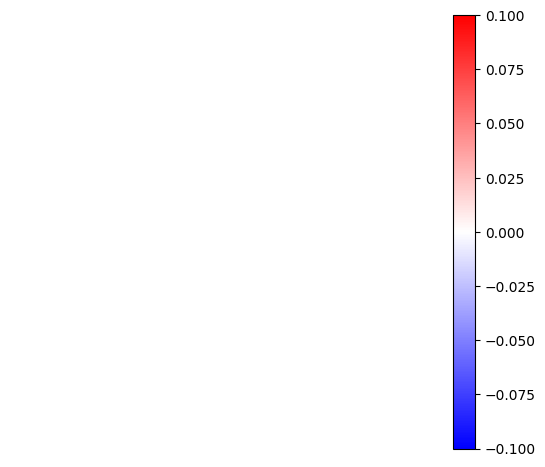

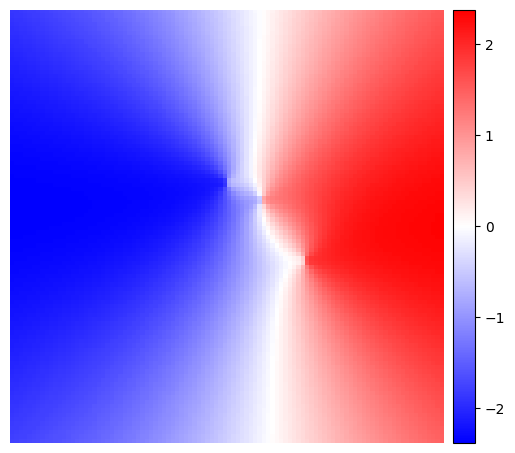

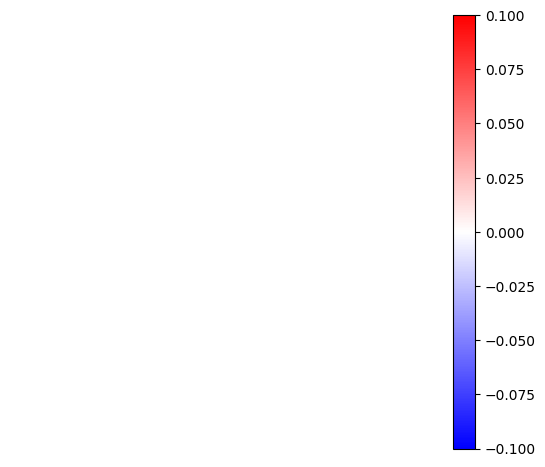

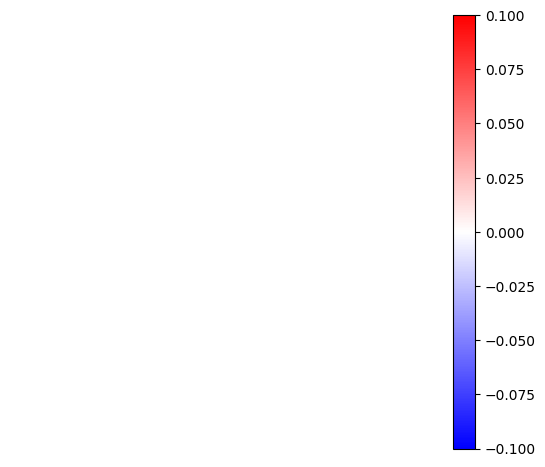

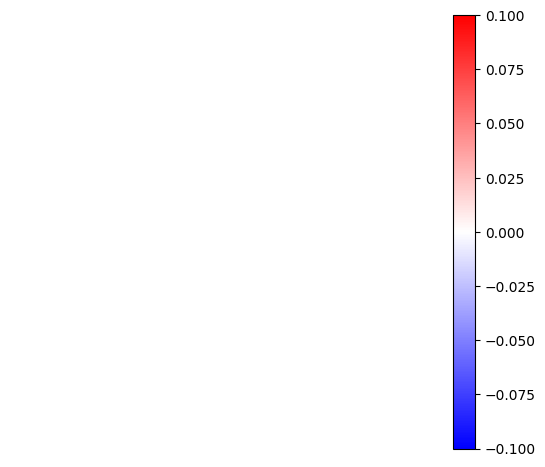

AssertionError: 

In [13]:
lens_test_helper(lens, lens_ls, z_s, params, kwargs_ls, rtol, atol, test_Psi=False, test_kappa=False)

In [10]:
lens

MultiplaneLens(
    name='multiplane',
    static=[],
    dynamic=[],
    x keys=[('sie-0': ['z_l', 'thx0', 'thy0', 'q', 'phi', 'b']), ('sie-1': ['z_l', 'thx0', 'thy0', 'q', 'phi', 'b']), ('sie-2': ['z_l', 'thx0', 'thy0', 'q', 'phi', 'b'])]
)